# Tutorial for offline processing of motor-imagery data
Data is taken from BCI Competition III (dataset IIIa)

https://www.bbci.de/competition/iii/download/index.html?agree=yes&submit=Submit

https://www.bbci.de/competition/iii/desc_IIIa.pdf

In [181]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [395]:
streams = mne.io.read_raw_gdf('k3b.gdf', preload=True, verbose=False)
print(streams)

<RawGDF | k3b.gdf, 60 x 986780 (3947.1 s), ~451.8 MB, data loaded>


Note: The above code yields important information about our data variable 'streams': 

the data contain 60 EEG channels, each channel is not named (therefore mne simply refers to them #1, #2,...). The data has been lowpassed at 125Hz. The data was acquired sometimes in 2019, and the sampling frequency is 250Hz.

In [396]:
# To convert the data to numpy array, simply use 'get_data()'
data = streams.get_data()
print(data)
print(data.shape)

[[-7.90066262e-08  4.04342380e-06  5.50937427e-06 ...  1.64903802e-06
   2.36424416e-06 -8.32386748e-06]
 [ 3.02789735e-06  8.48467092e-06  8.82619360e-06 ...  9.42955035e-06
   1.23249038e-05 -1.44604983e-06]
 [ 3.43533997e-06  8.33021130e-06  8.84878034e-06 ...  7.94128451e-06
   9.07653026e-06 -2.91362699e-06]
 ...
 [ 9.61291819e-06  1.30364655e-05  1.31918497e-05 ...  2.12539980e-05
   1.91397537e-05  7.39932994e-06]
 [ 7.88201031e-06  1.17419958e-05  1.26554098e-05 ...  2.09990060e-05
   1.87966119e-05  8.47781587e-06]
 [ 7.96728648e-06  1.20509279e-05  1.30982923e-05 ...  1.52318924e-05
   1.40635952e-05  6.58519737e-06]]
(60, 986780)


Note: The resulting variable should have a shape (60, xxxxx). 60 indicates 60 EEG channels, and xxxxx indicates the total number of samples

Effective window size : 8.192 (s)


/var/folders/1t/6vc2cgrd0cq5q50xfcv4m_2m0000gn/T/ipykernel_57652/2719802942.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  streams.compute_psd().plot()
/Users/thi.cha/miniconda3/envs/bcienv_arm64/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


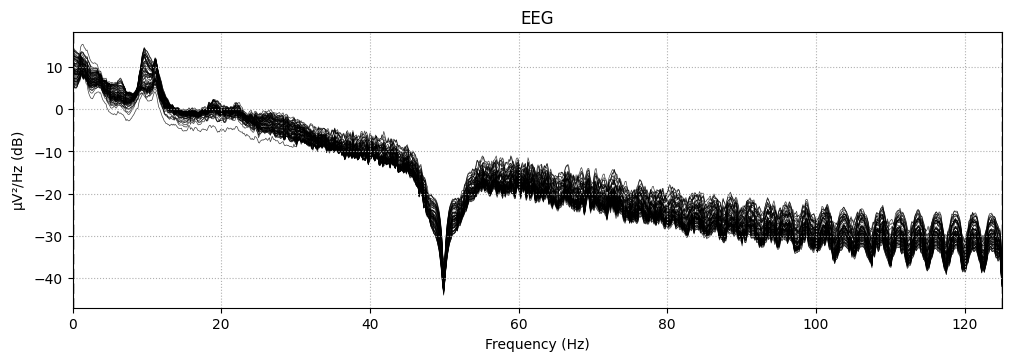

In [397]:
# visualize data
streams.compute_psd().plot()

Note: As you can see in the psd plot, the example data has already been notch-filtered to remove power line noise (at around 50Hz). so we don't need to worry about power line noise in this current data.

# Channel information

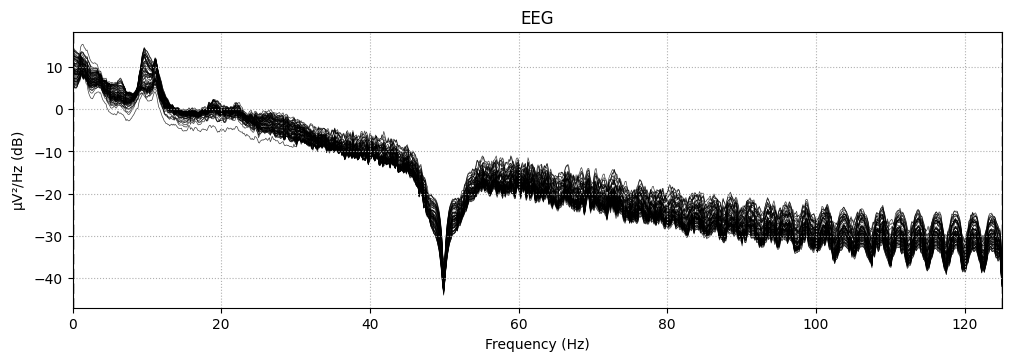

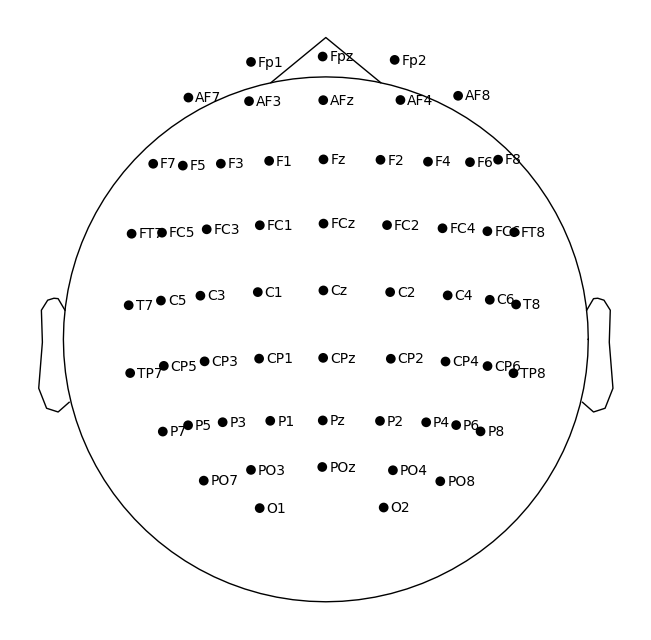

In [398]:
# Rename electrode channels
# Let's assume they use 10-20 system
chan_mapping = {
    '# 1': 'Fp1', '# 2': 'Fpz', '# 3': 'Fp2', '# 4': 'AF7', '# 5': 'AF3',
    '# 6': 'AFz', '# 7': 'AF4', '# 8': 'AF8', '# 9': 'F7',  '# 10': 'F5',
    '# 11': 'F3', '# 12': 'F1', '# 13': 'Fz',  '# 14': 'F2', '# 15': 'F4',
    '# 16': 'F6', '# 17': 'F8', '# 18': 'FT7', '# 19': 'FC5', '# 20': 'FC3',
    '# 21': 'FC1', '# 22': 'FCz', '# 23': 'FC2', '# 24': 'FC4', '# 25': 'FC6',
    '# 26': 'FT8', '# 27': 'T7',  '# 28': 'C5',  '# 29': 'C3',  '# 30': 'C1',
    '# 31': 'Cz',  '# 32': 'C2',  '# 33': 'C4',  '# 34': 'C6',  '# 35': 'T8',
    '# 36': 'TP7', '# 37': 'CP5', '# 38': 'CP3', '# 39': 'CP1', '# 40': 'CPz',
    '# 41': 'CP2', '# 42': 'CP4', '# 43': 'CP6', '# 44': 'TP8', '# 45': 'P7',
    '# 46': 'P5',  '# 47': 'P3',  '# 48': 'P1',  '# 49': 'Pz',  '# 50': 'P2',
    '# 51': 'P4',  '# 52': 'P6',  '# 53': 'P8',  '# 54': 'PO7', '# 55': 'PO3',
    '# 56': 'POz', '# 57': 'PO4', '# 58': 'PO8', '# 59': 'O1',  '# 60': 'O2'
}

# New channel names
channel_names = [chan_mapping[f'# {i+1}'] for i in range(60)]

# Get old channel names
old_ch_names = streams.info['ch_names']

# Rename all channels
streams.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
streams.set_montage(montage)

# Plot channel locations
streams.plot_sensors(show_names=True);


Effective window size : 8.192 (s)


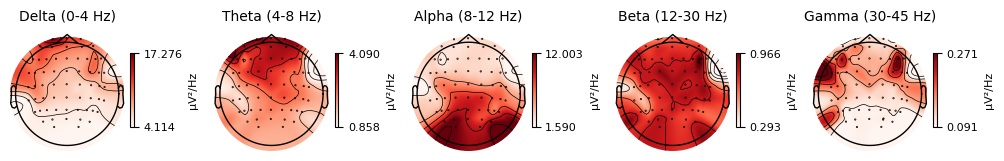

In [399]:
streams.compute_psd().plot_topomap();

# Re-reference (CAR)

In [400]:
streams = streams.copy().set_eeg_reference('average', projection=True)
streams.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,"May 19, 2003 13:22:09 GMT"
Experimenter,Unknown
Participant,k3
Digitized points,63 points
Good channels,60 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


# Bandpass filter

In [401]:
# Apply bandpass filtering (8-11Hz) to extract data in the alpha frequency
streams_alpha = streams.filter(l_freq=8.0, h_freq=11.0, fir_design='firwin', verbose=False)

# Events

In [402]:
# Extract events and event_dict (event dictionary) from the data
events, event_dict = mne.events_from_annotations(streams_alpha)
print(event_dict)

Used Annotations descriptions: ['1023', '768', '769', '770', '771', '772', '783', '785', '786']
{'1023': 1, '768': 2, '769': 3, '770': 4, '771': 5, '772': 6, '783': 7, '785': 8, '786': 9}


Note: event_dict (event dictionary: a variable that indicates the mapping between event names to numeric codes)

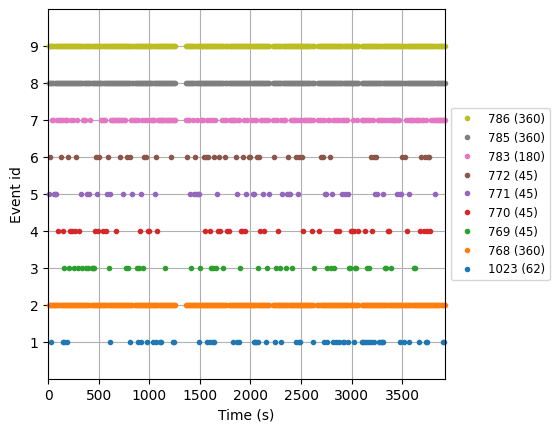

/var/folders/1t/6vc2cgrd0cq5q50xfcv4m_2m0000gn/T/ipykernel_57652/3755607428.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [403]:
# Plotting events
fig = mne.viz.plot_events(
    events, sfreq=streams_alpha.info["sfreq"], first_samp=streams_alpha.first_samp, event_id= event_dict
)
ax = fig.axes[0]
x_lim_seconds = [10, 20]
ax.set_xlim(x_lim_seconds)
fig.show()

Note: Based on the plot above, we can guess that '769', '770', '771', '772' are event codes for the four motor-imagery classes in the dataset. 

Unfortunately, the dataset description (https://www.bbci.de/competition/iii/desc_IIIa.pdf) does not provide details about what these event codes mean. But we can guess:

769: left hand
770: right hand
771: foot
772: tongue


# Epoch data

In [404]:
# Epoch data based on a subset of interested events
event_selected = {'left': 3, 'right': 4, 'foot': 5, 'tongue': 6}

epochs = mne.Epochs(streams_alpha, events, tmin = -2.0, tmax = 5.0, 
                    event_id = event_selected, preload= True, verbose=False)

In [405]:
# Selected data from only the channels we are interested in
chans_selected = ['C5','C3','C1','Cz','C2','C4','C6']
epochs_mi = epochs.pick_channels(chans_selected)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [406]:
# Examine the structure of the created variable 'epochs_mi'. we need to convert 'epochs_mi' to numpy array variable first.
data = epochs_mi.get_data()

print(data.shape)

(180, 7, 1751)


/var/folders/1t/6vc2cgrd0cq5q50xfcv4m_2m0000gn/T/ipykernel_57652/2618493583.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_mi.get_data()


Note: This will return (180, 7, 2501) (for k3b.gdf)

180 --> total number of epochs (4 class, each class 45 epochs)

7 --> total number of channels selected (C4, C2b, C2a, Cz, C1a, C1b, C3)

2501 --> total number of datapoints per epoch (10 secs per epoch x sampling rate 250 samples per sec)

# Plot ERD

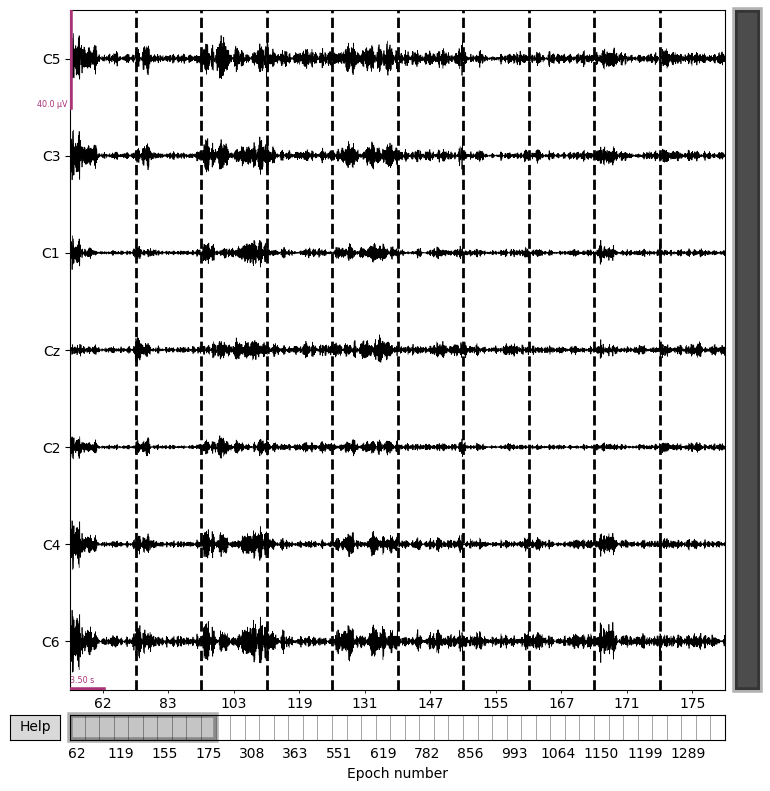

In [407]:
epochs['left'].plot(n_epochs=10);


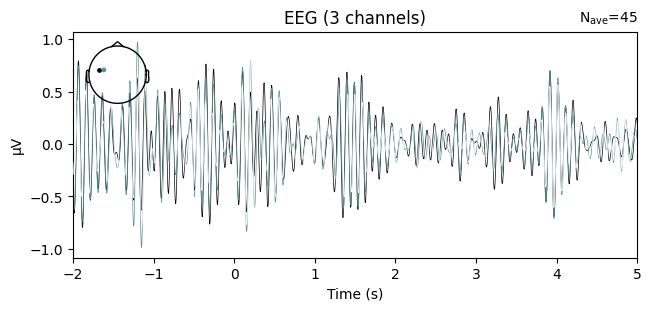

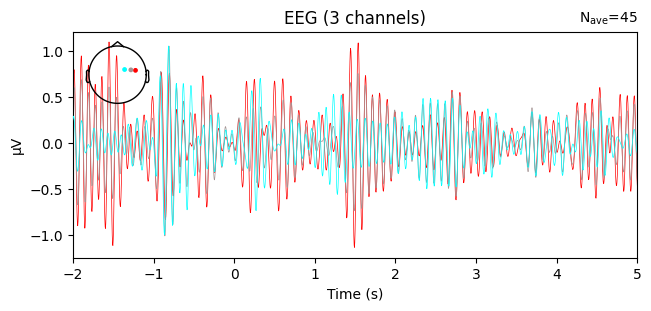

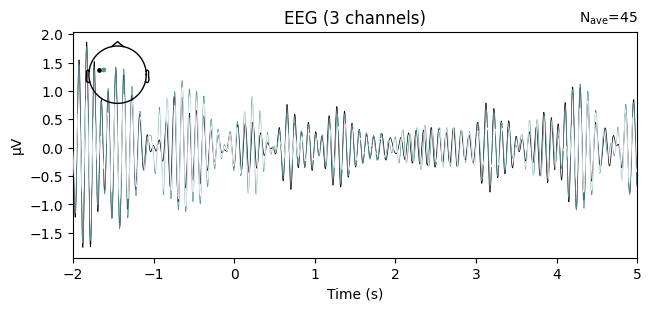

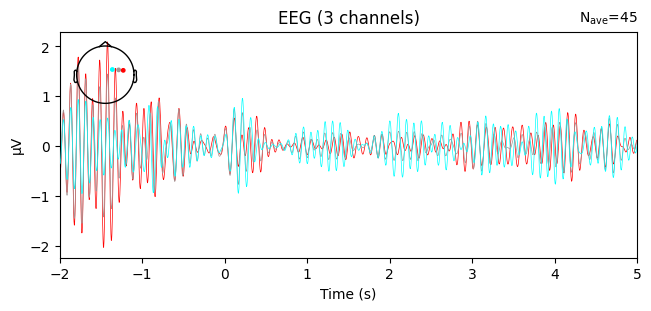

In [408]:
right_electrodes = ['C6','C4','C2']
left_electrodes = ['C5','C3','C1']
central_electrode = 'Cz'

epochs_mi['right'].average().plot(picks=left_electrodes);
epochs_mi['right'].average().plot(picks=right_electrodes);

epochs_mi['left'].average().plot(picks=left_electrodes);
epochs_mi['left'].average().plot(picks=right_electrodes);


Need more than one channel to make topography for eeg. Disabling interactivity.


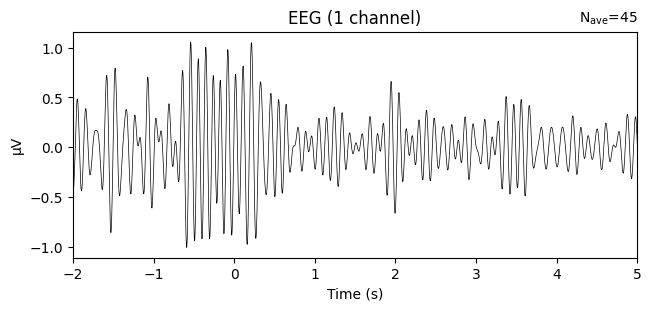

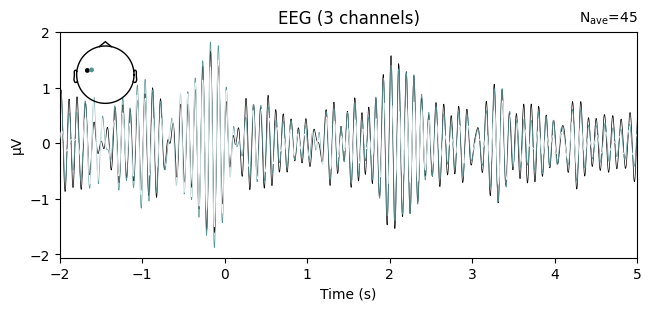

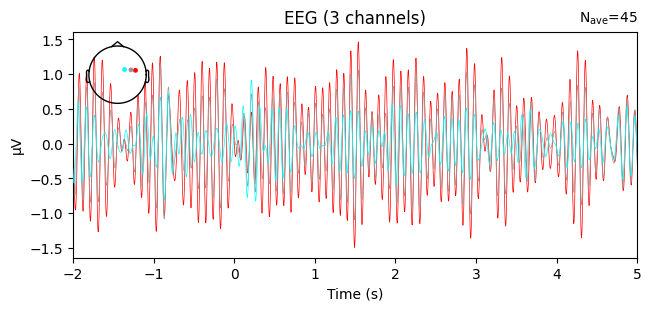

Need more than one channel to make topography for eeg. Disabling interactivity.


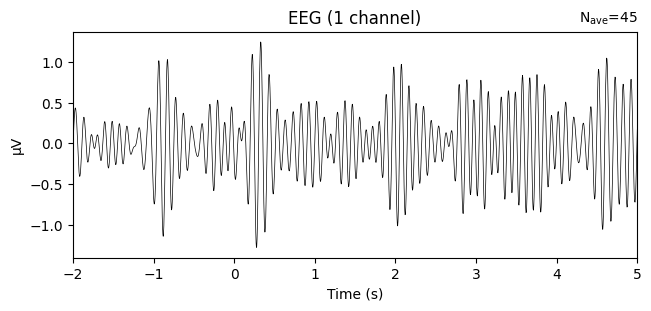

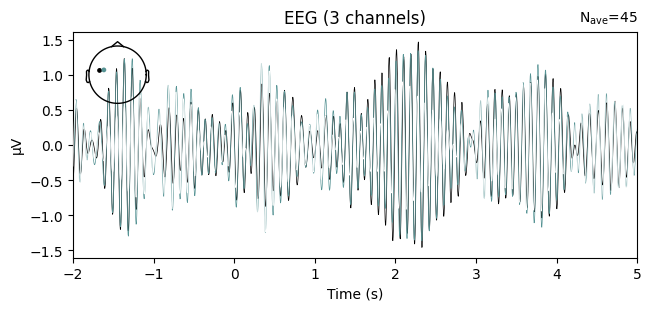

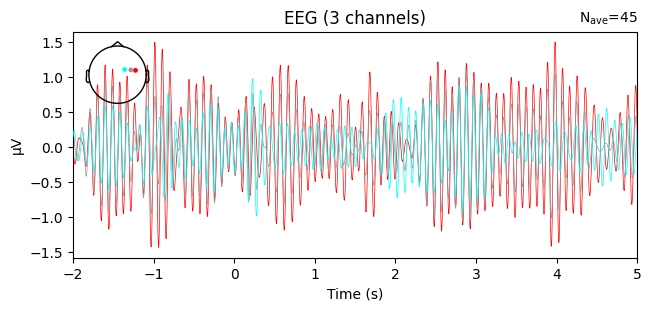

In [409]:
# Comparing foot and tongue
epochs_mi['foot'].average().plot(picks= central_electrode);
epochs_mi['foot'].average().plot(picks= left_electrodes);
epochs_mi['foot'].average().plot(picks= right_electrodes);

epochs_mi['tongue'].average().plot(picks= central_electrode);
epochs_mi['tongue'].average().plot(picks= left_electrodes);
epochs_mi['tongue'].average().plot(picks= right_electrodes);

Note: As you can see from the above plots, clear event-related desynchronization (ERD) can be observed for the left electrodes for right motor imagery task, and vice versa.

The pattern is probably clearer for the right motor imagery task though.

In [410]:
# Create a function for plotting epoch data
def plot_ERD(data, sf=250.0):
    
    # Square data 
    data = np.square(data)
    print(data.shape)

    # Calculate the average across epochs for each channel
    averaged_data = np.mean(data, axis=0)
    
    # Create time vector based on the sampling rate and number of time points
    time_points = averaged_data.shape[0]
    time = np.arange(0, time_points) / sf - 5.0
    
    # Set up the plot
    plt.figure(figsize=(8, 6))
    
    # Plot    
    plt.plot(time, averaged_data)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.title('Event-Related Desynchronization')
    plt.show()

In [411]:
print(data.shape[0])

180


In [412]:
# Select events
x = data.shape[0]

epochs_L_l = data[ : int(x*.25), 0, :]
epochs_L_r = data[ : int(x*.25), 2, :]

epochs_R_l = data[int(x*.25) : int(x*.5), 0, :]
epochs_R_r = data[int(x*.25) : int(x*.5), 2, :]

epochs_R = data[int(x*.25) : int(x*.5), :, :]
epochs_F = data[int(x*.5) : int(x*.75), :, :]
epochs_T = data[int(x*.75) : x, :, :]

(45, 1751)


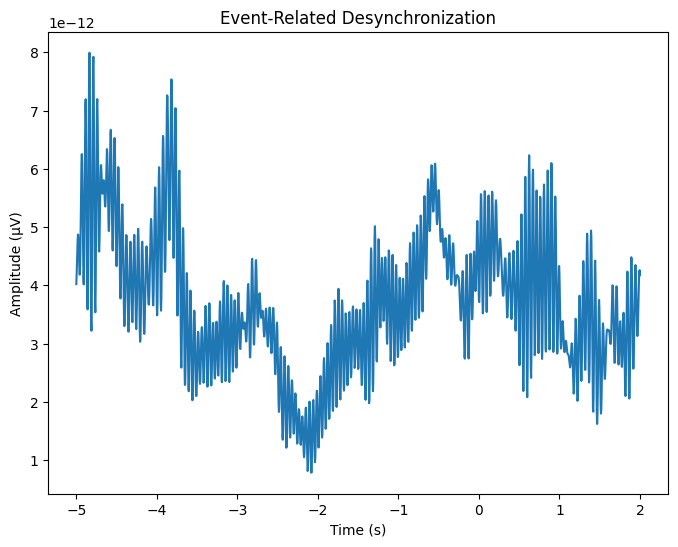

In [413]:
plot_ERD(epochs_L_r, sf = 250.0);

# Feature extraction using CSP

In [414]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split, cross_val_score

Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 7 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 7 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


/var/folders/1t/6vc2cgrd0cq5q50xfcv4m_2m0000gn/T/ipykernel_57652/2096001243.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs_mi.get_data()


    Using tolerance 2.9e-06 (2.2e-16 eps * 7 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-06 (2.2e-16 eps * 7 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


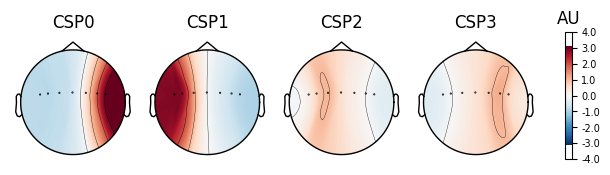

In [415]:
# Get EEG data and events
X = epochs_mi.get_data()
y = epochs_mi.events[:, -1]

# Initilize CSP
csp = CSP(n_components = 4, norm_trace = False)

# Fit CSP to data 
csp.fit(X, y)

# Visualize CSP patterns
csp.plot_patterns(epochs_mi.info);

# Logistic regression

In [416]:
# Transform data into CSP space
X_transformed = csp.transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.2, random_state = 42)

In [417]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
from sklearn.metrics import classification_report

# Create and fit the logistic regression model within a pipeline
clf = Pipeline([('LR', LogisticRegression())])
clf.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred, target_names=['Left', 'Right','Foot','Tongue'])  
print(report)


Accuracy: 0.75
              precision    recall  f1-score   support

        Left       0.71      0.62      0.67         8
       Right       0.67      0.80      0.73         5
        Foot       0.75      0.82      0.78        11
      Tongue       0.82      0.75      0.78        12

    accuracy                           0.75        36
   macro avg       0.74      0.75      0.74        36
weighted avg       0.75      0.75      0.75        36



EXPLANATION:

Accuracy - overall accuracy of the model (proportion of all predictions that were correct) 

Precision - ratio of correctly predicted positive observations to the total predicted positives E.g., e.g., precision is 0.71 means that 71% of the instances predicted as L were truly L.

Recall (aka sensitivity or true positive rate) - ratio of correctly predicted positive observations to all observations in the actual class. e.g., L recall = 0.62 --> means that 62% of the actual L instances were correctly identified by the model

F1-score - weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0. It is a measure of the model's accuracy that considers both precision and recall. E.g., F1-score for class L is 0.67, indicating a balance between precision and recall for this class.

Support - number of actual occurrences of the class in the dataset


# SVM

In [418]:
from sklearn.svm import SVC 

clf = Pipeline([('SVM', SVC(kernel='linear'))])  
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred, target_names=['Left', 'Right','Foot','Tongue'])  # adjust target names accordingly
print(report)

Accuracy: 0.6944444444444444
              precision    recall  f1-score   support

        Left       0.71      0.62      0.67         8
       Right       0.80      0.80      0.80         5
        Foot       0.64      0.82      0.72        11
      Tongue       0.70      0.58      0.64        12

    accuracy                           0.69        36
   macro avg       0.71      0.71      0.71        36
weighted avg       0.70      0.69      0.69        36



# LDA

In [419]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = Pipeline([('LDA', LDA())])
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred, target_names=['Left', 'Right','Foot','Tongue']) 
print(report)

Accuracy: 0.6944444444444444
              precision    recall  f1-score   support

        Left       0.71      0.62      0.67         8
       Right       0.67      0.80      0.73         5
        Foot       0.64      0.82      0.72        11
      Tongue       0.78      0.58      0.67        12

    accuracy                           0.69        36
   macro avg       0.70      0.71      0.70        36
weighted avg       0.71      0.69      0.69        36



# Cross validation

In [420]:
# CSP-LDA pipeline

csp = CSP(n_components=4, log=True, norm_trace=False)
lda = LDA()

pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

scores = cross_val_score(pipeline, X, y, cv=5)  # 5-fold cross-validation
print(scores)

Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 7 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 7 dim * 1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-06 (2.2e-16 eps * 7 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 7 dim * 1.5e+09  max singular value)
    Estimated rank (m